# Тестовое задание 

   Ваша задача написать пайплайн для тренировки модели глубоко обучения (любую – **embeddings + LSTM, Bert** …) с использованием следующих инструментов: pytorch, sklearn, matplotlib – для решения задачи **NER** (извлечения сущностей).

   В качестве данных используется датасет **Conll2003** с четырьмя классами **Per, Org, Loc, Misc** в формате **Conll**.

   В тетрадке ниже заданы основные классы и функции для построения требуемого пайплайн, какие-то уже имплементированы, какие-то – нет. Их требуется доработать. Тем не менее если данный набор абстракций вам не подходит Вы можете написать свой пайплайн «с нуля», однако у этих действий должно быть обоснование.

**Что оценивается в первую очередь:**
- Выбранная архитектура для решения задачи (генеративная/экстрактивная)
- Выбранные предобученные веса 
- Полученные метрики
- Анализ ошибок модели

**Затем:**
- Глубина разведочного анализа (EDA)
- Испольуземые инстурменты для сравнения экспериментов
- Какая схема теггирования используется (**BIO, IO** или другие)
- Каким образом производится расчет метрик (потокенный отчет, отчет по точному совпадению спанов сущностей)

**С меньшим приоритетом:** 
- Скорость предобработки и постобработки данных 
- Стиль кода

In [ ]:
! pip install transformers

In [1]:
from torch.utils.data import Dataset, DataLoader
from typing import List
import collections
from collections import Counter, defaultdict
from tqdm import tqdm, trange
import importlib
import sys
import os
import time
import math
from random import shuffle
from IPython.display import clear_output
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import gensim
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

import torch
from torch import nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.distributed import DistributedSampler
from transformers import BertTokenizerFast
from transformers import AdamW
from transformers import AutoTokenizer, AutoModelForTokenClassification , AutoConfig
from transformers import BertModel
from transformers import  DistilBertForTokenClassification, BertForTokenClassification

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union, Tuple, Dict

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
%matplotlib inline

In [3]:
%config InlineBackend.figure_format = 'retina'
# mlp.rcParams['figure.dpi'] = 50
plt.rcParams["figure.figsize"] = (10,8)
plt.style.use('ggplot') 

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

-----------
# Функции

In [5]:
# read data
def read_data(file: str):
  lines = open(file, "r").readlines()
  data = {"sentences": [], "labels_per_sent": []}
  sentence, labels = [], []
  for line in tqdm(lines):
    line = line.strip()
    if not line:
      if sentence and labels:
        assert len(sentence) == len(labels)
        data["sentences"].append(sentence)
        data["labels_per_sent"].append(labels)
        sentence, labels = [], []
      continue
    if line.startswith("-DOCSTART-"):
      continue
    else:
      values = line.split(" ")
      try:
        token, _, _, label = values
        sentence.append(token)
        if label != 'O':
          labels.append(label.split('-')[-1])
        else:
          labels.append(label)

      except Exception as e:
        print(f"Error has occur: {e}")
        continue
  return data


In [6]:
# visualize labels
def get_label_distribution(labels: List[List[str]]):
  labels = [label for labels_per_sent in labels for label in labels_per_sent]
  return Counter(labels)

def visualize_distr(data: Counter):
  labels = list(data.keys())
  plt.bar(x=labels, height=list(data.values()))
  plt.show()

In [7]:
# create dicts for lstm
def build_dict(tokens: List , special_tokens: List) -> Tuple[Dict]:

    """
    :param tokens: a list of lists of tokens or tags
    :param special_tokens: some special tokens
    :return tokens mappings
    """

    # create dictionaries
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    # adding specical tokens/tags to the dict
    for index, stoken in enumerate(special_tokens):
        tok2idx[stoken] = index
    
    # take unique tokens
    unique_tok_set = set()
    for item in tokens:
        for token in item:
            if token not in special_tokens:
                unique_tok_set.add(token)
    
    # iterate through lists and assign unique ids to tokens
    for index, utoken in enumerate(unique_tok_set, len(special_tokens)):
        tok2idx[utoken] = index
        
    # for index, utoken in enumerate(unique_tok_set, len(special_tokens)):
    #     tok2idx[utoken] = index
    sortedDict = sorted(tok2idx.items(),  key=lambda x: x[1])
    
    # reverse
    for elem in sortedDict :
        idx2tok.append(elem[0])
    
    return tok2idx, idx2tok

In [8]:
# create embeddigs
def get_emb_matrix(word_vecs, token2idx: Dict, emb_size: int = 300, special_ids: Tuple[int] = (0, 1)) -> np.ndarray:
    """
    create embedding matrix from word vectors
    :param word_vecs: keyed vectors
    :param token2idx: tok->id mapping
    :param emb_size: embeddings dimension
    :param special_ids: special tokens ids
    :return embeddings matrix
    """

    # int matrix
    W = np.zeros((len(token2idx), emb_size), dtype="float32")

    # add special tokens
    W[0] = np.zeros(emb_size, dtype='float32') 
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) 

    # add embedding wor a word if its in vocab
    for word, id in token2idx.items():
      if id not in special_ids:
        if word in word_vecs:
            W[id] = word_vecs[word]
        else:
            W[id] = np.random.uniform(-0.25,0.25, emb_size)
    return W

In [9]:
# NERdataset for LSTM training

class NERDataset(Dataset):

  def __init__(self, data: List[Tuple], pad_to: int = None, pad_to_char: int = None, pad_value: int = 0, 
                 pad_left: bool = False, pad_left_char: bool = False, is_char=False) -> None:

    """
    NER dataset class
    :param data: tuple with sequences
    :param pad_to: padding length
    :param pad_to_char: char padding length
    :param pad_value: padding id
    :param pad_left: whether add padding at the beggining of sentence
    :param pad_left_char: whether add padding at the beggining of word
    :param is_char: whether to add chars
    """
    self.pairs = data
    self.pad_to = pad_to
    self.pad_to_char = pad_to_char
    self.pad_left_char = pad_left_char
    self.pad_value = pad_value
    self.pad_left = pad_left
    self.is_char = is_char

  def __getitem__(self, ix: int) -> Dict:

    """
    :param ix: index of object
    :return object prepared for training 
    """
    # create dict with necessary fields
    if self.is_char:
      tokens, chars, tags = self.pairs[ix]
      tokens, chars, tags = self.transform(data=tokens), self.transform(data=chars, is_char=True), self.transform(data=tags)
      mask = [0 if token == self.pad_value else 1 for token in tokens]
      # mask = torch.tensor(mask, dtype=torch.int)
      res = {'tokens': tokens, 'chars': chars, 'labels': tags}
    else:

      tokens, tags = self.pairs[ix]
      tokens, tags = self.transform(data=tokens), self.transform(data=tags)
      res = {'tokens': tokens, 'labels': tags}
    return res
    
  def __len__(self):
    return len(self.pairs)
  
  def transform(self,  data: List, is_char: int = False):

    """
    add padding to data
    :param data: data to process
    :param is_char: whether add chars
    :return tensor prepared for training
    """

    # add padding of required len
    if not is_char:
      if self.pad_to is not None and len(data) != self.pad_to:
        if len(data) > self.pad_to:
          data = data[:self.pad_to]
        else:
          n_pads = self.pad_to - len(data)
          data = [self.pad_value]*n_pads*self.pad_left + \
                        data + \
                        [self.pad_value]*n_pads*(not self.pad_left)     
      return torch.tensor(data, dtype=torch.int)  

    # process chars embedding
    else:
      chars_embeddings = []
      for word in data:
        if self.pad_to_char is not None and len(word) != self.pad_to_char:
          if len(word) > self.pad_to_char:
            word = word[:self.pad_to_char]
          else:
            n_pads = self.pad_to_char - len(word)
            word = [self.pad_value]*n_pads*self.pad_left + \
                          word + \
                        [self.pad_value]*n_pads*(not self.pad_left_char)    
        chars_embeddings.append(word)  
      if self.pad_to is not None and len(chars_embeddings) != self.pad_to:
        if len(chars_embeddings) > self.pad_to:
          chars_embeddings = chars_embeddings[:self.pad_to]
        else:
          n_pads = self.pad_to - len(chars_embeddings)
          chars_embeddings = [[self.pad_value]*self.pad_to_char]*n_pads*self.pad_left + \
                        chars_embeddings + \
                        [[self.pad_value]*self.pad_to_char]*n_pads*(not self.pad_left)  
    
      return torch.tensor(chars_embeddings, dtype=torch.int)



---------

base model BiLSTM + pretrained embeddings

In [10]:
# base model

class NERModel(nn.Module):

  def __init__(self, 
               vocab_size: int, 
               embedding_dim: int, 
               hidden_dim: int, 
               output_dim: int, 
               n_layers: int, 
               bidirectional: bool, 
               dropout: float, 
               embeddings: Union[None, np.ndarray] = None,
               pad_idx: int = 0, 
               rnn: str = "LSTM"):
    
    """
    Simple bi LSTM / GRU class
    """
    super().__init__()
    self.rnn_type = rnn

    # init embedding, if pretrained provided - add weights
    self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
    if type(embeddings) == np.ndarray:
      print('add pretrained embeddings')
      self.embeddings.weight.data.copy_(torch.from_numpy(embeddings))

    # rnn 
    if rnn == 'LSTM':
          self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0,
                            batch_first=True )
    else:
          self.gru = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0,
                            batch_first=True )
    # classifier      
    self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, text):

    embedded = self.dropout(self.embeddings(text))
    if self.rnn_type == "LSTM":
      outputs, (hidden, cell) = self.lstm(embedded)
    else:
      outputs, _ = self.gru(embedded)

    predictions = self.fc(self.dropout(outputs))
    return predictions

In [11]:
# target transformation

def transform_target(target_labels: List[torch.tensor], idx2tag: List):
  return [idx2tag[i] for i in target_labels.numpy().ravel()]

def transform_tokens(tokens: List[torch.tensor], idx2tag: List):
  return [idx2token[i] for i in tokens.numpy().ravel()]

In [12]:
# accuracy

def accuracy_model(model, iterator,  TAG_PAD_IDX=0, exclude_pad_index=True):
    model.eval()
    
    true_pred = 0
    num_pred = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            
            words = batch['tokens']
            tags = batch['labels']
            tags = tags.type(torch.LongTensor)   
            words, tags = words.to(device), tags.to(device)
            output = model(words) 
            
            output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices 
            tags = tags.view(-1)
           
            predict_tags = output.cpu().numpy()
            true_tags = tags.cpu().numpy()
            
            if exclude_pad_index:
              true_pred += np.sum((true_tags == predict_tags) & (true_tags != TAG_PAD_IDX))
              num_pred += np.prod(true_tags.shape) - (true_tags == TAG_PAD_IDX).sum()
            else:
              true_pred += np.sum(true_tags == predict_tags)
              num_pred += np.prod(true_tags.shape).sum()
             
            
    return round(true_pred / num_pred * 100, 3)

In [13]:
# return predictions

def get_preds(model, iterator,  text=False, TAG_PAD_IDX=0, exclude_pad=True):
  model.eval()
  preds = []
  tags_given = []
  if text:
    text_l =[]
  with torch.no_grad():
        for i, batch in enumerate(iterator):

            words = batch['tokens']
            tags = batch['labels']

            tags = tags.type(torch.LongTensor)  
            words, tags = words.to(device), tags.to(device)
            output = model(words) 
            if text:
                words1 = words.view(-1).cpu().numpy()
            output = torch.max(F.softmax(output.view(-1, output.shape[-1]), dim=-1), dim=-1).indices 
            tags = tags.view(-1)

            predict_tags = output.squeeze().cpu().numpy()
            
            true_tags = tags.cpu().numpy()
            if exclude_pad:
              args = np.where(true_tags!=TAG_PAD_IDX)[0]

              predict_tags = predict_tags[args]
              true_tags = true_tags[args]
            if text:
              words1 = words1[args]

            if i==0:
              preds = predict_tags
              tags_given = true_tags
              if text:
                text_l = words1
            else:
              preds = np.append(preds, predict_tags)
              tags_given = np.append(tags_given, true_tags)
              if text:
                text_l = np.append(text_l, words1)
  if text:
    return preds, tags_given, text_l
  else:
    return preds, tags_given
     

In [14]:
# classic train loop

def train_loop(model, train_dataloader, valid_dataloader, optimizer, criterion, idx2tag, epochs=5, pad_idx=0, clip=1):

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(epochs):

        classes = []
        predicted_classes = []
        epoch_acc_train = 0
        epoch_loss_train = 0

        # ----------------
        # training
        model.train()

        for batch in tqdm(train_dataloader):
            
            train_label = batch['labels'].type(torch.LongTensor)   
            train_label = train_label.squeeze(1).to(device)
            texts = batch['tokens'].squeeze(1).to(device)

            optimizer.zero_grad()
            logits = model(texts)

            logits = logits.view(-1, logits.shape[-1])
            train_label = train_label.view(-1)
            loss = criterion(logits, train_label) ###

            predictions = logits.argmax(dim=1)
            true_pred = ((train_label == predictions) & (train_label != pad_idx)).sum()
            num_pred = (train_label != pad_idx).sum()
            acc = true_pred / num_pred
            epoch_acc_train += acc

            loss.backward()
       
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
            optimizer.step()
            epoch_loss_train += loss.item()

        train_accuracy = epoch_acc_train / len(train_dataloader)
        train_loss = epoch_loss_train / len(train_dataloader)

        # ----------------
        # evaluation
        model.eval()

        epoch_acc_valid = 0
        epoch_loss_valid = 0

        for batch in valid_dataloader:
            valid_label = batch['labels'].type(torch.LongTensor)
            valid_label = valid_label.to(device)
            texts = batch['tokens'].squeeze(1).to(device)
    
            optimizer.zero_grad()
            logits = model(texts)

            logits = logits.view(-1, logits.shape[-1])
            valid_label = valid_label.view(-1)
            loss = criterion(logits, valid_label) ###

            epoch_loss_valid += loss.item()
            
            predictions = logits.argmax(dim=1)
            true_pred = ((valid_label == predictions) & (valid_label != pad_idx)).sum()
            num_pred = (valid_label != pad_idx).sum()
            acc = true_pred / num_pred
            epoch_acc_valid += acc

            predicted_classes.extend(predictions.cpu().numpy())
            classes.extend(valid_label.cpu().numpy())
        
        valid_accuracy = epoch_acc_valid / len(valid_dataloader)
        valid_loss = epoch_loss_valid / len(valid_dataloader)

        # total_accuracy = (epoch_acc_train + epoch_acc_valid) / (len(train_dataloader) + len(valid_dataloader))
        # total_loss =  (epoch_loss_train + epoch_loss_valid) / (len(train_dataloader) + len(valid_dataloader))
        print(
            f'Epochs: {epoch_num + 1} | Train_Loss: {train_loss: .3f} | Train_Accuracy: {train_accuracy: .3f} | Val_Loss: {valid_loss: .3f} | Val_Accuracy: {valid_accuracy: .3f}')
        count_metrics(classes, predicted_classes, idx2tag)

In [15]:
# metrics

def get_f1_score(model, iterator, is_char=False):
  from sklearn.metrics import f1_score
  preds, tags = get_preds(model, iterator, is_char)
  f1_score_macro = f1_score(tags, preds, average='macro') * 100
  f1_score_micro = f1_score(tags, preds, average='micro') * 100
  return f1_score_macro, f1_score_micro

  
def count_metrics(gold_labels_per_sentence: List, predict_labels_per_sentence: List, idx2tag):
  gold_labels = [idx2tag[l] for l in gold_labels_per_sentence]
  predict_labels = [idx2tag[l] for l in predict_labels_per_sentence]
  print(classification_report(gold_labels, predict_labels))

------------------
BERT

In [16]:
# metric controller

class Metrics():
  """
  Model evaluation during training
  """
  def __init__(self):

    self.total_acc = 0
    self.total_f1 = 0
    self.total_precision = 0
    self.total_recall = 0

  def update(self, predictions, labels , ignore_token = -100):
    """
    add new portion of predictions
    :param predictions: predicted classes
    :param labels: true classes
    :param ignore_token: token that is irrelevant to us 
    """ 

    # get all labels except ignore token
    predictions = predictions.flatten()
    labels = labels.flatten()
    predictions = predictions[labels != ignore_token]
    labels = labels[labels != ignore_token]
    predictions = predictions.to("cpu")
    labels = labels.to("cpu")

    # count metrics
    acc = accuracy_score(labels,predictions)
    f1 = f1_score(labels, predictions, average = "macro")
    precision = precision_score(labels, predictions, average = "macro")
    recall = recall_score(labels, predictions, average = "macro")

    # update
    self.total_acc  += acc
    self.total_f1 += f1
    self.total_precision += precision
    self.total_recall  += recall

  def return_avg_metrics(self, data_loader_size):
    """
    return metrics statistics
    :param data_loader_size: number of batches
    """
    n = data_loader_size
    metrics = {
        "acc": round(self.total_acc / n ,3), 
        "f1": round(self.total_f1 / n, 3), 
        "precision" : round(self.total_precision / n, 3), 
        "recall": round(self.total_recall / n, 3)
          }
    return metrics   

In [17]:
# classic train loop but for bert

def train_loop_bert(model, train_dataloader, dev_dataloader, optimizer, epochs=5):

  for epoch in range(epochs): 

    # -----------
    # train     
    train_metrics = Metrics()
    total_loss_train = 0

    model.train()

    for train_data, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)

      # get components for bert
      mask = train_data['attention_mask'].squeeze(1).to(device)
      input_id = train_data['input_ids'].squeeze(1).to(device)

      optimizer.zero_grad()
      
      output = model(input_id, mask, train_label)
      loss, logits = output.loss, output.logits
      predictions = logits.argmax(dim= -1) 

      #compute metrics
      train_metrics.update(predictions, train_label)
      total_loss_train += loss.item()

      #grad step
      loss.backward()
      optimizer.step()
    
    # -----------
    # evaluate          
    model.eval()

    dev_metrics = Metrics()
    total_loss_dev = 0
    
    with torch.no_grad():
      for dev_data, dev_label in dev_dataloader:

        dev_label = dev_label.to(device)

        # get components for bert
        mask = dev_data['attention_mask'].squeeze(1).to(device)
        input_id = dev_data['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask, dev_label)
        loss, logits = output.loss, output.logits

        predictions = logits.argmax(dim= -1)     

        dev_metrics.update(predictions, dev_label)
        total_loss_dev += loss.item()
    
    train_results = train_metrics.return_avg_metrics(len(train_dataloader))
    dev_results = dev_metrics.return_avg_metrics(len(dev_dataloader))

    print(f"TRAIN \nLoss: {total_loss_train / len(train_dataloader)} \nMetrics {train_results}\n" ) 
    print(f"VALIDATION \nLoss {total_loss_dev / len(dev_dataloader)} \nMetrics{dev_results}\n" )   

In [18]:
# tags alignment

def match_tokens_labels(tokenized_input, tags, tag2idx, ignore_token = -100):
        '''
        align tokens and tags after bpe tokenization
        -100 will be tha label used to match additional tokens like [CLS] [PAD] that we dont care about. 
        :param tokenized_input: bert tokenization result
        :param tags: labels
        :return: a list of labels that match the tokenized text -> [-100, 3,5,6,-100,...]
        '''

        # gives an array [ None , 0 , 1 ,2 ,... None]. Each index tells the word of reference of the token
        word_ids = tokenized_input.word_ids()

        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:

            if word_idx is None:
                label_ids.append(ignore_token)

            # if its equal to the previous word 
            # we can add the same label id of the provious or -100 
            else :
                try:
                  reference_tag = tags[word_idx]
                  label_ids.append(tag2idx[reference_tag])
                except:
                  label_ids.append(ignore_token)
                        
            previous_word_idx = word_idx

        return label_ids

In [19]:
# build tags dict

def tags_mapping(tags_lists : List):
  """
  make labels mapping
  :param tags_lists: labels
  :return dictionary tag2idx (label), 
  idx2tag, 'O' label, unique tokens
  """

  unique_tags = set([i for subset in tags_lists for i in subset]) 
  for tag_list in tags_lists:
    for tag in tag_list:
      unique_tags.add(tag)

  tag2idx = {k:v for v,k in enumerate(sorted(unique_tags))}
  idx2tag = {k:v for v,k in tag2idx.items()}

  unseen_label = tag2idx["O"]

  return tag2idx, idx2tag, unseen_label, unique_tags

In [20]:
# simple dataset class

class NerBertDataset(Dataset):
  """
  Custom dataset for BERT tagger
  """
  
  def __init__(self, data: Dict, tag2idx: Dict, max_len=124, tag_column="labels_per_sent"):

    """
    :param data: dictionary with tokens and tags
    :param tag2idx: mapping for tags: tag -> int
    :param max_len: maximum sequence len
    """
    
    tags_list = data[tag_column]
    texts = [' '.join(i) for i in data["sentences"]]
    
    # save tokenized texts and aligned labels
    self.texts = [tokenizer(text, padding = "max_length", truncation = True, max_length=max_len, return_tensors = "pt") for text in texts]
    self.labels = [match_tokens_labels(text, tags, tag2idx) for text,tags in zip(self.texts, tags_list)]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    batch_text = self.texts[idx]
    batch_labels = self.labels[idx]

    return batch_text, torch.LongTensor(batch_labels)

In [21]:
# simple bert model

class BertNER(nn.Module):
  
  def __init__(self, bert):
    """
    :param tokens_dim: output_dim
    """
    super(BertNER, self).__init__()

    # only bert here
    self.pretrained = bert 


  def forward(self, input_ids, attention_mask, labels = None): 
    # labels are needed in order to compute the loss
    # inference time - no labels
    if labels == None:
      out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask )
      return out

    out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask , labels = labels)
    return out

In [22]:
# get output bert

def get_preds_bert(model, dataloader, idx2tag, ignore_token=-100):
  true_labels = []
  predictions_all = []

  with torch.no_grad():
    for data, labels in dataloader:

        labels = labels.to(device)
        
        # get components for bert
        mask = data['attention_mask'].squeeze(1).to(device)
        input_id = data['input_ids'].squeeze(1).to(device)

        # get pred
        output = model(input_id, mask, labels)
        loss, logits = output.loss, output.logits
        predictions = logits.argmax(dim=-1)  

        # to -> cpu -> numpy
        predictions = predictions.flatten()
        labels = labels.flatten()
        predictions = predictions[labels != ignore_token]
        labels = labels[labels != ignore_token]
        predictions = predictions.to("cpu").numpy()
        labels = labels.to("cpu").numpy()
        true_labels.extend(list(labels))
        predictions_all.extend(list(predictions))
        
  # map ids to tags
  true_labels = [idx2tag[i] for i in true_labels]
  predictions_all = [idx2tag[i] for i in predictions_all]
  return true_labels, predictions_all


-----------------------------

# Загрузка данных

In [ ]:
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.testa
!wget https://raw.githubusercontent.com/synalp/NER/master/corpus/CoNLL-2003/eng.train

In [28]:
!head eng.train 

-DOCSTART- -X- O O

EU NNP I-NP I-ORG
rejects VBZ I-VP O
German JJ I-NP I-MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP I-MISC
lamb NN I-NP O


In [23]:
train = read_data("eng.train")
valid = read_data("eng.testa")

100%|██████████| 55045/55045 [00:00<00:00, 506244.78it/s]


In [24]:
train["sentences"][0], train["labels_per_sent"][0]

(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['ORG', 'O', 'MISC', 'O', 'O', 'O', 'MISC', 'O', 'O'])

In [25]:
valid["sentences"][0], valid["labels_per_sent"][0]

(['CRICKET',
  '-',
  'LEICESTERSHIRE',
  'TAKE',
  'OVER',
  'AT',
  'TOP',
  'AFTER',
  'INNINGS',
  'VICTORY',
  '.'],
 ['O', 'O', 'ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'])

Train distribution


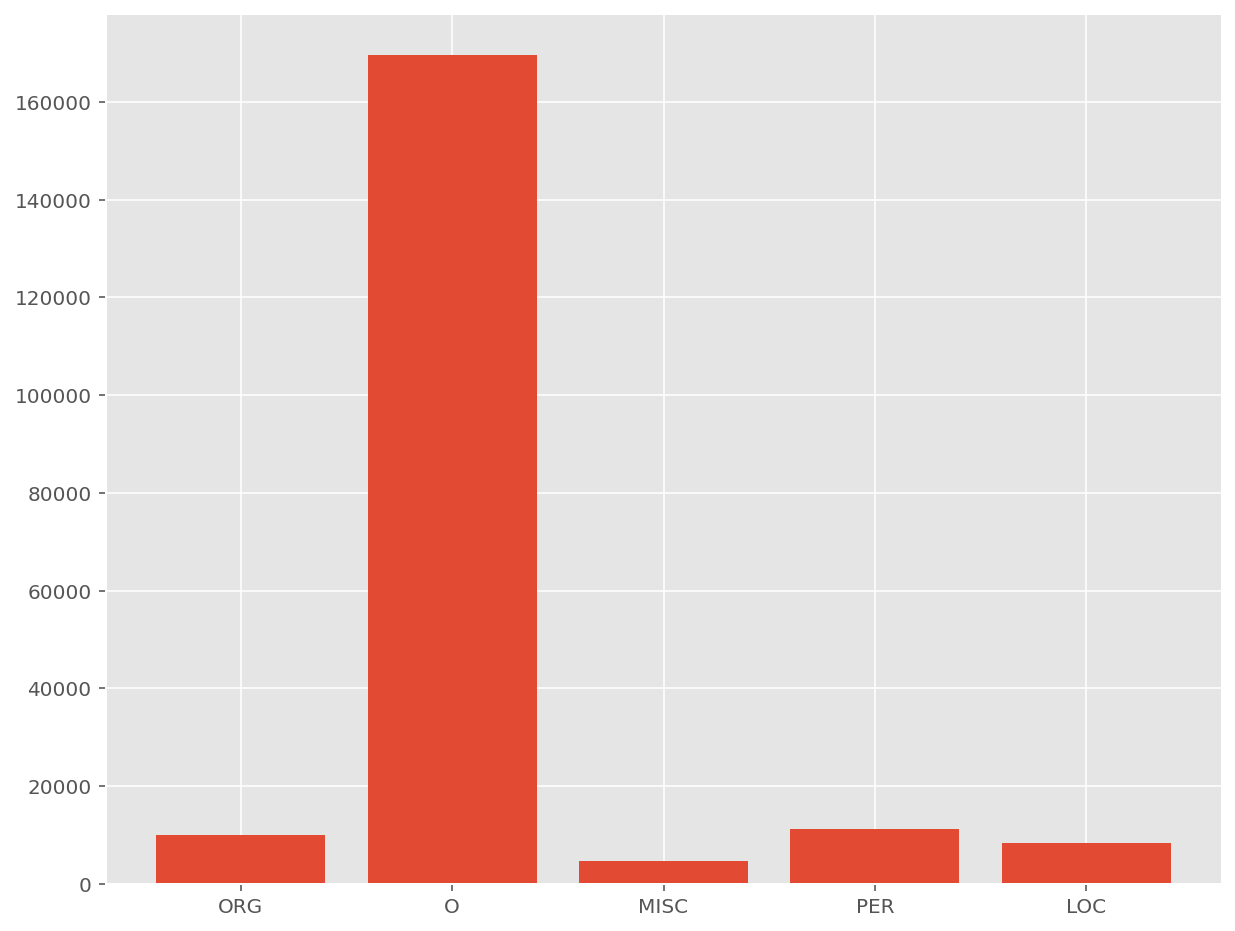

Valid distribution


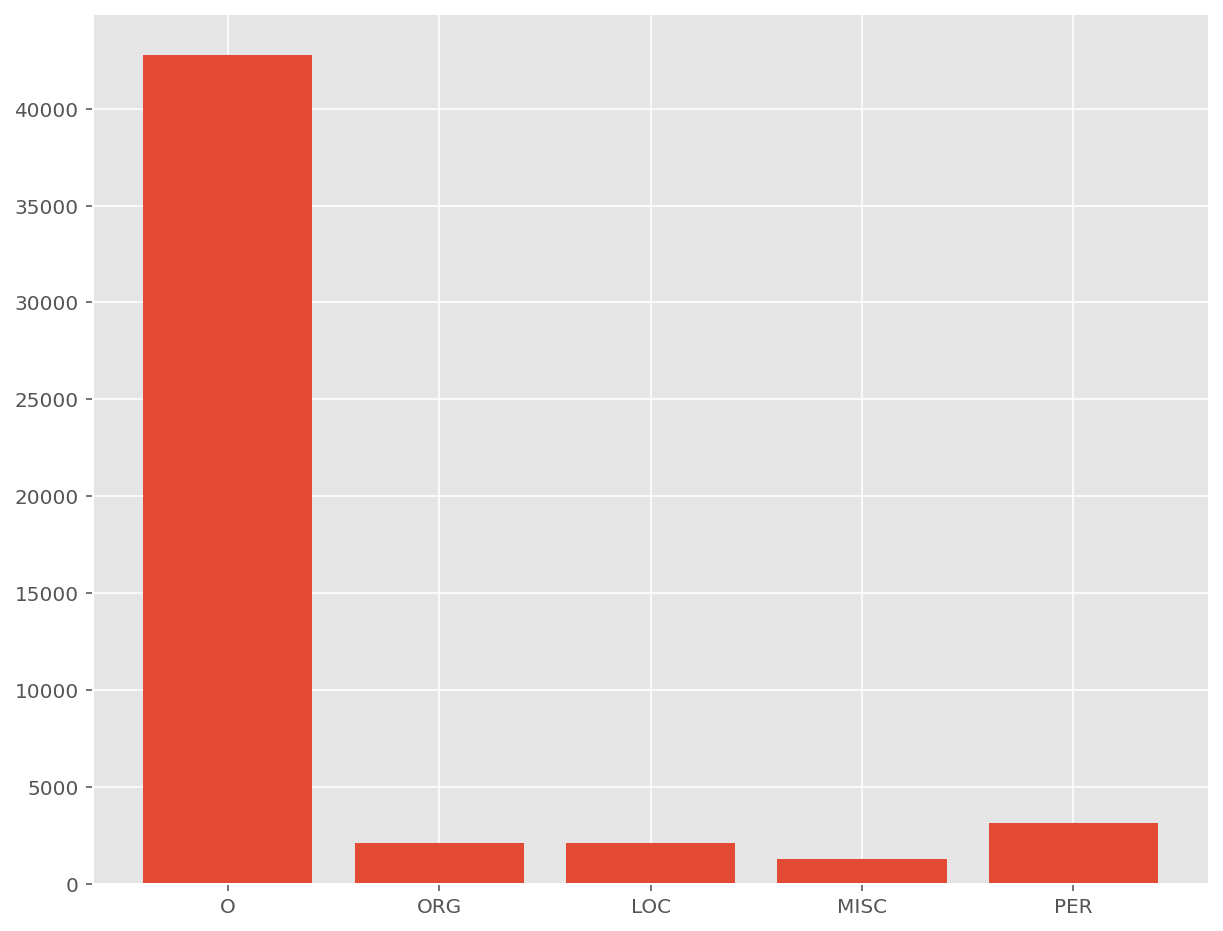

In [26]:
train_distribution = get_label_distribution(train["labels_per_sent"])
valid_distribution = get_label_distribution(valid["labels_per_sent"])

print("Train distribution")
visualize_distr(train_distribution)
print("Valid distribution")
visualize_distr(valid_distribution)

Очевидно, что классы сильно не сбалансированы в силу особенностей задачи. Если убрать класс `O`, то остальные распределены относительно равномерно с самым многочисленным классом `PER` и малочисленным `MISC`

# EDA

Проверить пересечения

Посмотрим на описательную статистику, а также распределения длин екстов

In [27]:
print(f"Number of training examples: {len(train['sentences'])}")
print(f"Number of validation examples: {len(valid['sentences'])}")

Number of training examples: 14041
Number of validation examples: 3250


In [28]:
train_len = list(map(lambda x: len(x), train['sentences']))
valid_len = list(map(lambda x: len(x), valid['sentences']))
max_len_train = max(train_len)
min_len_train = min(train_len)
mean_len_train = np.mean(train_len)

max_len_valid = max(valid_len)
min_len_valid = min(valid_len)
mean_len_valid = np.mean(valid_len)

print(f'Maximum sentence lenght in train: {max_len_train}')
print(f'Minimum sentence lenght in train: {min_len_train }')
print(f'Mean sentence lenght in train: {mean_len_train}')
print()
print(f'Maximum sentence lenght in valid: {max_len_valid}')
print(f'Minimum sentence lenght in valid: {min_len_valid}')
print(f'Mean sentence lenght in valid: {mean_len_valid}')

Maximum sentence lenght in train: 113
Minimum sentence lenght in train: 1
Mean sentence lenght in train: 14.501887329962253

Maximum sentence lenght in valid: 109
Minimum sentence lenght in valid: 1
Mean sentence lenght in valid: 15.803692307692307


In [29]:
Counter(train_len)[1], Counter(valid_len)[1]

(179, 15)

Есть примеры длины один. От них не особо много толку, но оставим


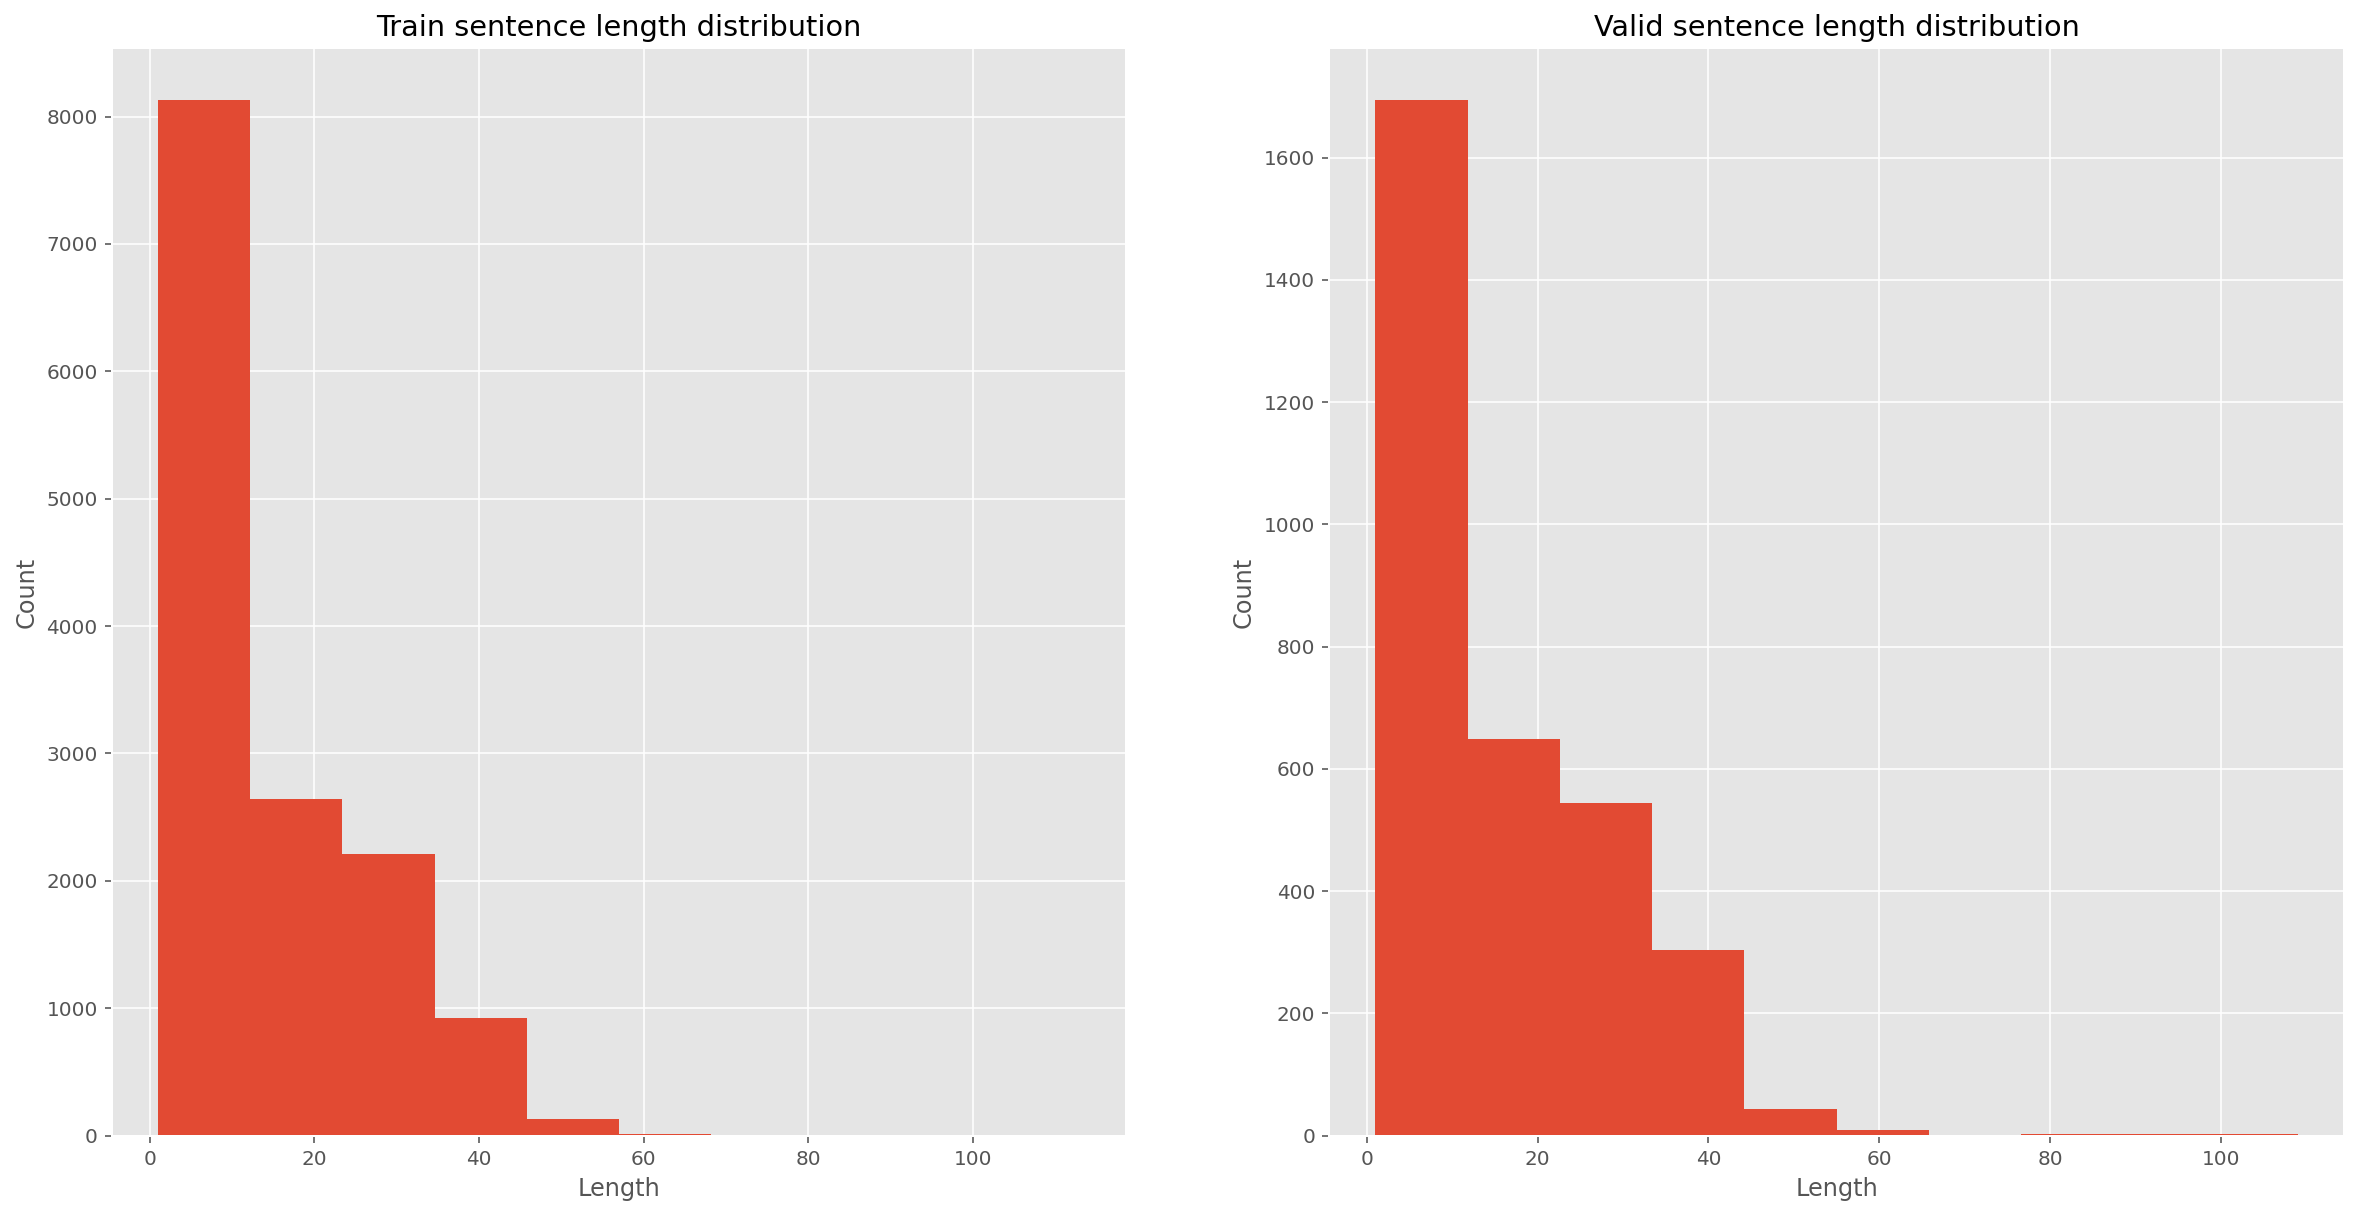

In [30]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(train_len)
plt.title('Train sentence length distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(valid_len)
plt.title('Valid sentence length distribution')
plt.xlabel('Length')
plt.ylabel('Count')

plt.show()

>95% распределения длин лежит в пределах от 0 до 60

In [31]:
train_tags = [item for sublist in train['labels_per_sent'] for item in sublist]
valid_tags = [item for sublist in valid['labels_per_sent'] for item in sublist]

In [32]:
stat_train = Counter(train_tags)
stat_valid = Counter(valid_tags)

In [33]:
stat_train = pd.DataFrame.from_dict(stat_train.items())
stat_train.columns = ['tag', 'count']
stat_train.set_index('tag', inplace=True)
stat_train.sort_values(by='count', ascending=False, inplace=True)
stat_train

,count
tag,
O,169578
PER,11128
ORG,10025
LOC,8297
MISC,4593


In [34]:
stat_valid = pd.DataFrame.from_dict(stat_valid.items())
stat_valid.columns = ['tag', 'count']
stat_valid.set_index('tag', inplace=True)
stat_valid.sort_values(by='count', ascending=False, inplace=True)
stat_valid 

,count
tag,
O,42759
PER,3149
LOC,2094
ORG,2092
MISC,1268


Можно заключить, что распределения в train / val  примерно совпадают (только `ORG` и `LOC` по-разному ранжируются). 

Основная проблема - несбалансированность классов и возможные пересечения

-------------------

# Эксперименты

В данном ноутбуке рассмотрим два подхода к решению задачи:

* `BiLSTM` + предобученные эмбеддинги в качестве хорошего бейзлайна 
* `BERT` как более продвинутое решение

Схему тэгирования  для начала оставляем той же, что была и ранее: `IO`. Она простая и не дробит классы на еще несколько более мелких, что еще больше усугубляет проблему дисбаланса и добавляет простор для ошибок. Но нельзя однозначно утверждать, что `BIO` буде обязательно хуже, поэтому в конце проведем эксперимент с этой схемой тегирования

Модели оцениваются потокенно


## Бейзлайн

Для решения задач с последовательностями хорошим классическим подходом являются реккурентные нейросетки. `BiLSTM`+`CNN embeddings` + `CRF` не так давно был State-of-the-Art, но и обычной двунаправленной реккурентной сети хватит для достижения неплохого качества. Также добавим предобученные эмбеддинги

Загрузим эмбеддинги


Возьмем `gloves`,  обученные на новостях, что соответствует нашим данным, которые также представляют из себя новостные статьи

In [ ]:
! wget https://www.dropbox.com/s/699kgut7hdb5tg9/GoogleNews-vectors-negative300.bin.gz?dl=1
! mv 'GoogleNews-vectors-negative300.bin.gz?dl=1' GoogleNews-vectors-negative300.bin.gz
! gunzip GoogleNews-vectors-negative300.bin.gz

In [41]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin', binary=True)

Приведем текст к нижнему регистру и нормализуем

In [46]:
# lowercase
lemmatizer = WordNetLemmatizer()
train_processed = []
for i in train["sentences"]:
  sentence = []
  for j in i:  
    if j.isalpha():
      sentence.append(lemmatizer.lemmatize(j.lower()))
    else:
      sentence.append(j.lower())
  train_processed.append(sentence)

valid_processed = []
for i in valid["sentences"]:
  sentence = []
  for j in i:
    if j.isalpha():
      sentence.append(lemmatizer.lemmatize(j.lower()))
    else:
      sentence.append(j.lower())
  valid_processed.append(sentence)

Добавим спецтокены в словарик

In [47]:
special_tokens = [ '<PAD>', '<UNK>']
special_tags = ['O']

token2idx, idx2token = build_dict(train_processed + valid_processed, special_tokens)
tag2idx, idx2tag = build_dict(train["labels_per_sent"], special_tags)

In [48]:
len(token2idx)

22299

Инициализируем матрицу эмбеддингов

In [49]:
w2v_embeddings = get_emb_matrix(w2v, token2idx, emb_size = 300)
print(f'Embeddings matrix shape: {w2v_embeddings.shape}')

Embeddings matrix shape: (22299, 300)


In [50]:
encoded_train = []
for sentence, tags in zip(train_processed, train['labels_per_sent']):
  sentence_enc = [token2idx[token] for token in sentence]
  tag_enc = [tag2idx[tag] for tag in tags]

  encoded_train.append((sentence_enc, tag_enc))

encoded_valid = []
for sentence, tags in zip(valid_processed, valid['labels_per_sent']):
  sentence_enc = [token2idx[token] for token in sentence]
  tag_enc = [tag2idx[tag] for tag in tags]

  encoded_valid.append((sentence_enc, tag_enc))


Непосредственно обучение


Замечания:

* padding берем 124: большинство текстов по длине меньше 70, но все же встречаются кейсы ближе к 100 и не хочется потерять драгоценные примеры с `MISC`. 

In [51]:
train_dataset = NERDataset(encoded_train, pad_to=124)
valid_dataset = NERDataset(encoded_valid, pad_to=124)

In [52]:
BATCH_SIZE = 32
train_datloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [53]:
INPUT_DIM = len(token2idx)
EMBEDDING_DIM = 300
HIDDEN_DIM = 228
OUTPUT_DIM = len(tag2idx)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25 
PAD_IDX = token2idx['<PAD>']

model = NERModel(vocab_size=INPUT_DIM,
               embedding_dim=EMBEDDING_DIM, 
               hidden_dim=HIDDEN_DIM, 
               output_dim=OUTPUT_DIM, 
               n_layers=N_LAYERS, 
               bidirectional=BIDIRECTIONAL, 
               dropout=DROPOUT, 
               embeddings=w2v_embeddings,
               pad_idx=PAD_IDX, 
               rnn="LSTM"
                 )

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)
model = model.to(device)

add pretrained embeddings


In [54]:
optimizer = optim.Adam(model.parameters(), lr=0.01) 

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [55]:
train_loop(model,  train_datloader, valid_dataloader, optimizer, criterion, idx2tag, epochs=4, pad_idx=0)

100%|██████████| 439/439 [00:14<00:00, 30.68it/s]


Epochs: 1 | Train_Loss:  0.030 | Train_Accuracy:  0.660 | Val_Loss:  0.019 | Val_Accuracy:  0.776
              precision    recall  f1-score   support

         LOC       0.91      0.86      0.89      2094
        MISC       0.92      0.72      0.80      1268
           O       1.00      1.00      1.00    394397
         ORG       0.91      0.62      0.74      2092
         PER       0.95      0.85      0.90      3149

    accuracy                           0.99    403000
   macro avg       0.94      0.81      0.86    403000
weighted avg       0.99      0.99      0.99    403000



100%|██████████| 439/439 [00:14<00:00, 30.23it/s]


Epochs: 2 | Train_Loss:  0.007 | Train_Accuracy:  0.919 | Val_Loss:  0.017 | Val_Accuracy:  0.846
              precision    recall  f1-score   support

         LOC       0.93      0.87      0.90      2094
        MISC       0.90      0.75      0.82      1268
           O       1.00      1.00      1.00    394397
         ORG       0.77      0.79      0.78      2092
         PER       0.92      0.91      0.92      3149

    accuracy                           1.00    403000
   macro avg       0.90      0.86      0.88    403000
weighted avg       1.00      1.00      1.00    403000



100%|██████████| 439/439 [00:14<00:00, 31.09it/s]


Epochs: 3 | Train_Loss:  0.004 | Train_Accuracy:  0.954 | Val_Loss:  0.020 | Val_Accuracy:  0.830
              precision    recall  f1-score   support

         LOC       0.91      0.87      0.89      2094
        MISC       0.93      0.75      0.83      1268
           O       1.00      1.00      1.00    394397
         ORG       0.84      0.73      0.78      2092
         PER       0.93      0.90      0.91      3149

    accuracy                           1.00    403000
   macro avg       0.92      0.85      0.88    403000
weighted avg       1.00      1.00      1.00    403000



100%|██████████| 439/439 [00:13<00:00, 32.58it/s]


Epochs: 4 | Train_Loss:  0.003 | Train_Accuracy:  0.967 | Val_Loss:  0.021 | Val_Accuracy:  0.831
              precision    recall  f1-score   support

         LOC       0.91      0.88      0.90      2094
        MISC       0.89      0.78      0.83      1268
           O       1.00      1.00      1.00    394397
         ORG       0.86      0.72      0.79      2092
         PER       0.92      0.89      0.90      3149

    accuracy                           1.00    403000
   macro avg       0.91      0.85      0.88    403000
weighted avg       1.00      1.00      1.00    403000



**Оценка качества**

Здесь качество оцениваем по токенам, как в обычной мультиклассовой классификации

In [56]:
print(f'Accuracy: {accuracy_model(model, valid_dataloader)}')

Accuracy: 83.169


F1

In [57]:
f1_score_macro, f1_score_micro = get_f1_score(model, valid_dataloader)
print(f'f1 macro: {f1_score_macro}. f1 micro: {f1_score_micro}')

f1 macro: 69.99871532201296. f1 micro: 83.16866209461816


Выведем также `classification report` и `confusion_matrix`

In [58]:
preds, true_labels = get_preds(model, valid_dataloader, exclude_pad=False)
preds = list(preds)
true_labels = list(true_labels)
count_metrics(true_labels, preds, idx2tag)

              precision    recall  f1-score   support

         LOC       0.91      0.88      0.90      2094
        MISC       0.89      0.78      0.83      1268
           O       1.00      1.00      1.00    394397
         ORG       0.86      0.72      0.79      2092
         PER       0.92      0.89      0.90      3149

    accuracy                           1.00    403000
   macro avg       0.91      0.85      0.88    403000
weighted avg       1.00      1.00      1.00    403000



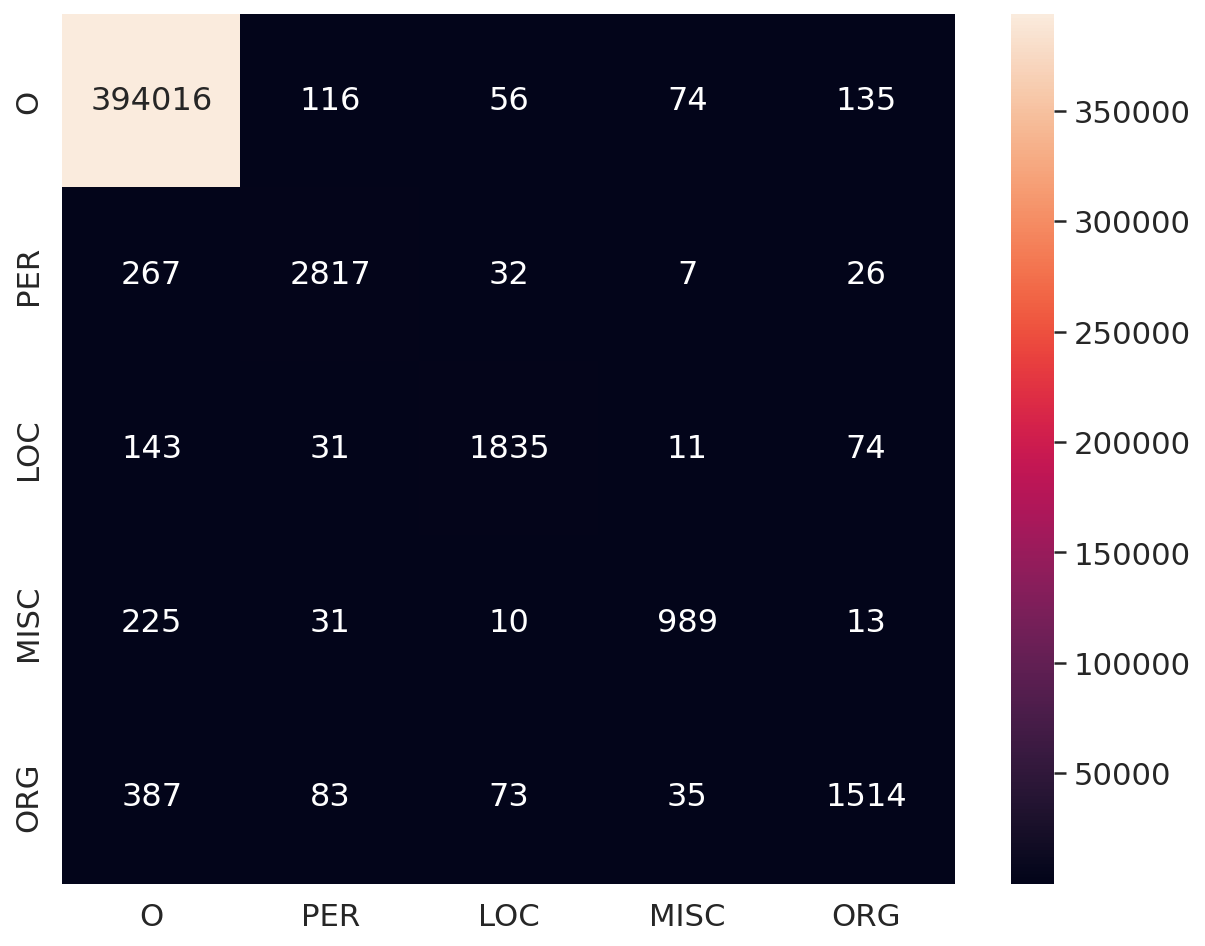

In [59]:
# plt.figure(figsize=(10,7))
df_cm = pd.DataFrame(confusion_matrix(true_labels, preds), index=list(tag2idx.keys()), columns=list(tag2idx.keys()))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".0f")
plt.show()

Микро выводы:

* Для всех классов достаточно большая путаница с `O` сохраняется, но в целом модель неплохо выявляет сущности
* Метрика `f1 macro` ожидаемо сильно хуже `f1 micro`, так как одинаково учитывает все классы, независимо от их численности, поэтому мажоритарный класс не обманывает нас, что все хорошо

Касательно самой модели:
* Плюс: дешево и сердито, обучается очень быстро и дает хороший бейзлайн
* Минусы: наличие лемматизации ведет к потере важной информации о конкретных формах слов и синтаксических зависимостях в тексте - например, мы точно теряем регистр, в результате чего качество страдает; а также нет `attention`, из-за чего фокус может смещен на незначимые, но частотные токены (`O`)

-------------------

## BERT

Данная архитектура позволяет хорошо выделять важные моменты в тексте благодаря механизму `self-attention`. А это дает ей важные преимущества в большинстве NLP-задач. Берт хорошо работает с последовательностями, поэтому для данной задачи должен показать более высокое качество

Воспользуемся здесь `bert-base-multilingual-cased` 

Это сильная модель, обученная на большом объеме текстов `Wikipedia`. Она чувствительна к регистру, что помогает лучше выявлять синтаксиеские зависимости и влияет на качество решения задачи. Ну и очевидно, многие именованные сущности начинаются с большой буквы, что нужно также учитывать

Из описания:

`This model is primarily aimed at being fine-tuned on tasks that use the whole sentence (potentially masked) to make decisions, such as sequence classification, token classification or question answering.`

Моделька хорошо подходит для классификации последовательностей, поэтому применим ее.

Делаем маппинги

In [90]:
tag2idx, idx2tag , unseen_label, unique_tags = tags_mapping(train['labels_per_sent'])

Инициализируем `tokenizer` и `Bert`

In [91]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

In [92]:
bert = BertForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels = len(tag2idx))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [93]:
model = BertNER(bert)
model.to(device)

print()

Инициализируем итераторы


In [94]:
train_dataset = NerBertDataset(train, tag2idx)
dev_dataset = NerBertDataset(valid, tag2idx)

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)

Теперь непосредственно к обучению

In [82]:
weight_decay_finetune = 1e-5 #0.01
learning_rate = 5e-5

optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8, 
                  weight_decay=weight_decay_finetune
                )

parameters = {
    "model": model,
    "train_dataloader": train_dataloader,
    "dev_dataloader" : valid_dataloader,
    "optimizer" : optimizer,
    "epochs" : 5
}

train_loop_bert(**parameters)

100%|██████████| 439/439 [04:46<00:00,  1.53it/s]


TRAIN 
Loss: 0.23194222652898563 
Metrics {'acc': 0.922, 'f1': 0.777, 'precision': 0.833, 'recall': 0.754}

VALIDATION 
Loss 0.13647959008812904 
Metrics{'acc': 0.951, 'f1': 0.866, 'precision': 0.896, 'recall': 0.853}



100%|██████████| 439/439 [04:49<00:00,  1.51it/s]


TRAIN 
Loss: 0.10511671534924003 
Metrics {'acc': 0.962, 'f1': 0.897, 'precision': 0.926, 'recall': 0.882}

VALIDATION 
Loss 0.12085897464524298 
Metrics{'acc': 0.954, 'f1': 0.882, 'precision': 0.923, 'recall': 0.859}



100%|██████████| 439/439 [04:50<00:00,  1.51it/s]


TRAIN 
Loss: 0.07182961401523245 
Metrics {'acc': 0.974, 'f1': 0.931, 'precision': 0.947, 'recall': 0.923}

VALIDATION 
Loss 0.12141107272028047 
Metrics{'acc': 0.959, 'f1': 0.895, 'precision': 0.892, 'recall': 0.909}



100%|██████████| 439/439 [04:50<00:00,  1.51it/s]


TRAIN 
Loss: 0.0568917413270801 
Metrics {'acc': 0.979, 'f1': 0.945, 'precision': 0.956, 'recall': 0.939}

VALIDATION 
Loss 0.10539011668194742 
Metrics{'acc': 0.964, 'f1': 0.903, 'precision': 0.922, 'recall': 0.894}



100%|██████████| 439/439 [04:51<00:00,  1.50it/s]


TRAIN 
Loss: 0.05052534050779133 
Metrics {'acc': 0.982, 'f1': 0.953, 'precision': 0.962, 'recall': 0.948}

VALIDATION 
Loss 0.11219610341861114 
Metrics{'acc': 0.967, 'f1': 0.91, 'precision': 0.928, 'recall': 0.901}



Оценим качество

In [83]:
true_labels, predictions_all = get_preds_bert(model, valid_dataloader, idx2tag, ignore_token=-100)

In [84]:
print(classification_report(true_labels, predictions_all))

              precision    recall  f1-score   support

         LOC       0.94      0.90      0.92      3384
        MISC       0.89      0.82      0.86      1787
           O       0.98      0.99      0.98     48459
         ORG       0.94      0.87      0.90      3356
         PER       0.90      0.94      0.92      4775

    accuracy                           0.97     61761
   macro avg       0.93      0.90      0.91     61761
weighted avg       0.97      0.97      0.97     61761



По сравнению с бейзлайном качество действительно подросло. Отстает немного `MISC` и `ORG`. `MISC` - самый немногочисленный, а `ORG`, видимо, сложнее распознается. Прежположу, что повышенная сложность этого класса может происходить из того факта, что многие названия состоят из самых обычных слов (типа `Apple` или `International Red Cross`), поэтому модели сложнее определять, просто ли перед ней слово с большой буквы или имя собственное 

А также `accuracy`

In [86]:
print(f'Accuracy: {accuracy_score(true_labels, predictions_all)}')

Accuracy: 0.9668884894998462


`Confusion Matrix`

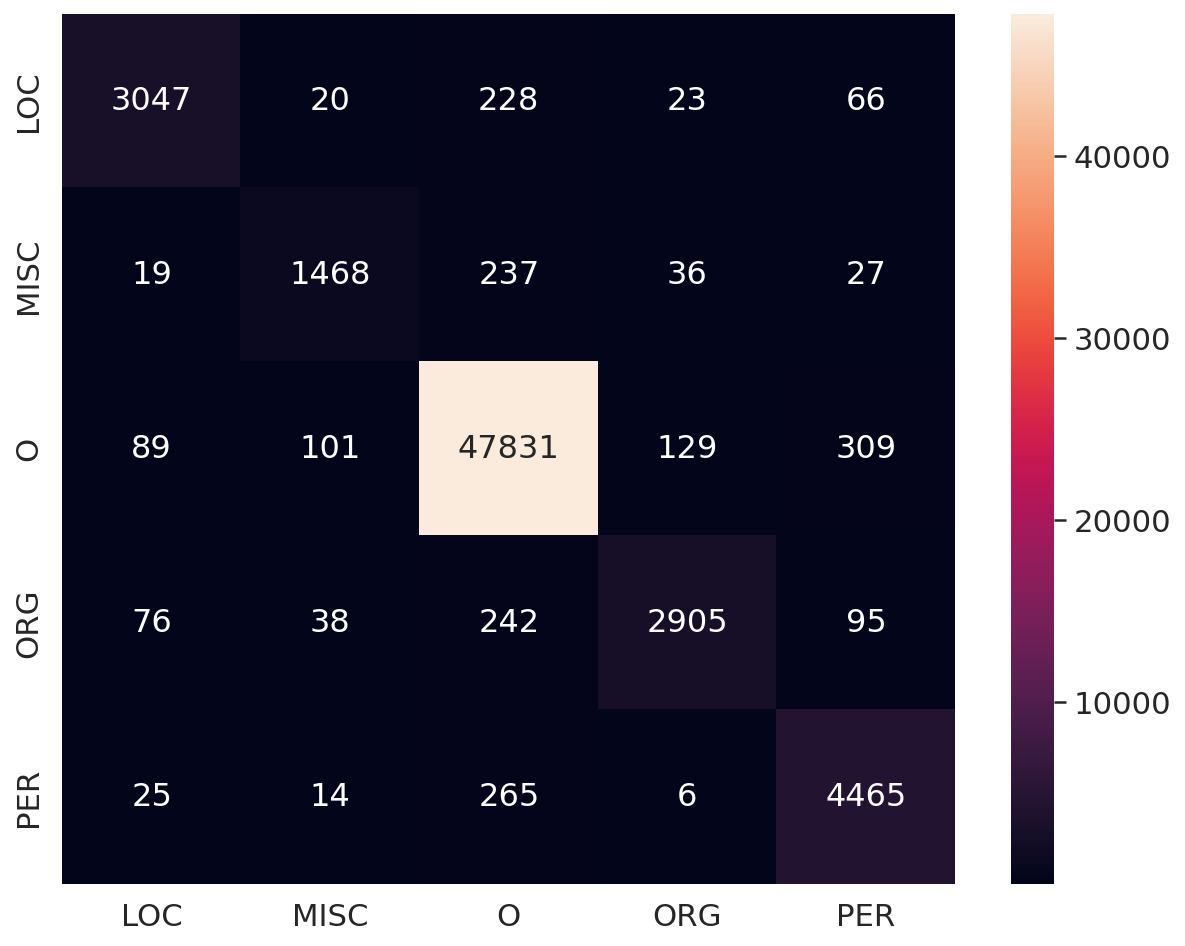

In [87]:
# plt.figure(figsize=(10,7))
df_cm = pd.DataFrame(confusion_matrix(true_labels, predictions_all), index=list(tag2idx.keys()), columns=list(tag2idx.keys()))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".0f") 

Микровыводы:

* применение `BERT` позволило значительно улучшить качество 
* Самым проблемным оказался ожидаемо самый малочисленный класс `MISC`


Из основных недостатков: хочется в задаче учитывать вероятности перехода от тэга к тэгу, так как их распределение не равномерно (особенно если сменить схему тэгирования), и перевзвешивать с их учетом выхода модели. 

Для этого обычно используют дополнительно `CRF`: его добавление - следующее возможное улучшение

Теперь попробуем поменять схему тэгирования

## BIO  tagging

`BIO` позволяет рассматривать спан не как набор отдельных токенов, а как сущность, где, строго говоря, есть разница между токеном начала и конца сущности.

Посмотрим, поможет ли схема `BIO` улучшить достигнутое качество?

In [34]:
bio_tags_train = []
for sent in train['labels_per_sent']:
  new_tags = []
  if len(sent) == 1:
    if sent[0] == 'O':
      new_tags.append('O')
    else:
      new_tags.append('B_' + sent[0])
  else:
    bos = sent[0]
    if bos == 'O':
      new_tags.append(bos)
    else:
      new_tags.append('B_' + bos)
    
    for i in range(1, len(sent) - 1):
      prev = sent[i - 1]
      next = sent[i + 1]
      curr = sent[i]
      # print(f'{prev}, {curr}, {next}') 
      if curr == 'O':
        new_tags.append(curr)
      elif prev != curr and curr != 'O':
        new_tags.append('B_'+curr)
      elif next != curr and curr != 'O':
        new_tags.append('E_'+curr)
      elif next == curr:
        new_tags.append('I_'+curr)

    if next == 'O':
      new_tags.append(next)
    elif next != 'O' and next != curr:
      new_tags.append('B_'+next)
    elif next != 'O' and next == curr:
      new_tags.append('E_'+next)

  bio_tags_train.append(new_tags)
  assert(len(sent) == len(new_tags))

 
train['bio_labels'] = bio_tags_train

In [35]:
bio_tags_valid = []
for sent in valid['labels_per_sent']:
  new_tags = []
  if len(sent) == 1:
    if sent[0] == 'O':
      new_tags.append('O')
    else:
      new_tags.append('B_' + sent[0])
  else:
    bos = sent[0]
    if bos == 'O':
      new_tags.append(bos)
    else:
      new_tags.append('B_' + bos)
    
    for i in range(1, len(sent) - 1):
      prev = sent[i - 1]
      next = sent[i + 1]
      curr = sent[i]
      # print(f'{prev}, {curr}, {next}') 
      if curr == 'O':
        new_tags.append(curr)
      elif prev != curr and curr != 'O':
        new_tags.append('B_'+curr)
      elif next != curr and curr != 'O':
        new_tags.append('E_'+curr)
      elif next == curr:
        new_tags.append('I_'+curr)

    if next == 'O':
      new_tags.append(next)
    elif next != 'O' and next != curr:
      new_tags.append('B_'+next)
    elif next != 'O' and next == curr:
      new_tags.append('E_'+next)

  bio_tags_valid.append(new_tags)
  assert(len(sent) == len(new_tags))

 
valid['bio_labels'] = bio_tags_valid

In [107]:
valid['labels_per_sent'][98]

['LOC', 'O', 'PER', 'PER', 'O', 'O', 'O', 'O', 'PER', 'PER', 'O', 'O', 'O']

In [108]:
valid['bio_labels'][98]

['B_LOC',
 'O',
 'B_PER',
 'E_PER',
 'O',
 'O',
 'O',
 'O',
 'B_PER',
 'E_PER',
 'O',
 'O',
 'O']

In [37]:
unique_tags

{'B_LOC',
 'B_MISC',
 'B_ORG',
 'B_PER',
 'E_LOC',
 'E_MISC',
 'E_ORG',
 'E_PER',
 'I_LOC',
 'I_MISC',
 'I_ORG',
 'I_PER',
 'O'}

Проверим также распределение полученных  тегов

In [100]:
train_tags_bio = [item for sublist in train['bio_labels'] for item in sublist]
valid_tags_bio = [item for sublist in valid['bio_labels'] for item in sublist]

stat_train = Counter(train_tags_bio)
stat_valid = Counter(valid_tags_bio)

In [101]:
stat_train = pd.DataFrame.from_dict(stat_train.items())
stat_train.columns = ['tag', 'count']
stat_train.set_index('tag', inplace=True)
stat_train.sort_values(by='count', ascending=False, inplace=True)
stat_train

,count
tag,
O,169749
B_LOC,7142
B_PER,6595
B_ORG,6307
E_PER,4210
B_MISC,3401
E_ORG,2455
I_ORG,1243
E_LOC,1045


In [102]:
stat_valid = pd.DataFrame.from_dict(stat_valid.items())
stat_valid.columns = ['tag', 'count']
stat_valid.set_index('tag', inplace=True)
stat_valid.sort_values(by='count', ascending=False, inplace=True)
stat_valid 

,count
tag,
O,42800
B_PER,1845
B_LOC,1841
B_ORG,1343
E_PER,1209
B_MISC,918
E_ORG,446
I_ORG,301
E_MISC,239


Оно опять же примерно совпадает, но некоторых классов теперь совсем немного


Пререйдем к обучению

In [36]:
tag2idx, idx2tag , unseen_label, unique_tags = tags_mapping(train['bio_labels'])

In [39]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

In [40]:
train_dataset = NerBertDataset(train, tag2idx, tag_column='bio_labels')
dev_dataset = NerBertDataset(valid, tag2idx, tag_column='bio_labels')

BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [43]:
bert = BertForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels = len(tag2idx))

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

In [44]:
model = BertNER(bert)
model.to(device)

print()

In [45]:
weight_decay_finetune = 1e-5 #0.01
learning_rate = 5e-5

optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8,
                  weight_decay=weight_decay_finetune
                )

parameters = {
    "model": model,
    "train_dataloader": train_dataloader,
    "dev_dataloader" : valid_dataloader,
    "optimizer" : optimizer,
    "epochs" : 5
}

train_loop_bert(**parameters)

100%|██████████| 439/439 [04:45<00:00,  1.54it/s]


TRAIN 
Loss: 0.31734437648215436 
Metrics {'acc': 0.909, 'f1': 0.583, 'precision': 0.641, 'recall': 0.568}

VALIDATION 
Loss 0.18460832485089115 
Metrics{'acc': 0.942, 'f1': 0.73, 'precision': 0.814, 'recall': 0.695}



100%|██████████| 439/439 [04:50<00:00,  1.51it/s]


TRAIN 
Loss: 0.13616518574450717 
Metrics {'acc': 0.957, 'f1': 0.801, 'precision': 0.844, 'recall': 0.787}

VALIDATION 
Loss 0.1580854625276783 
Metrics{'acc': 0.95, 'f1': 0.778, 'precision': 0.813, 'recall': 0.777}



100%|██████████| 439/439 [04:50<00:00,  1.51it/s]


TRAIN 
Loss: 0.09274166566160653 
Metrics {'acc': 0.97, 'f1': 0.865, 'precision': 0.891, 'recall': 0.859}

VALIDATION 
Loss 0.13843115930463754 
Metrics{'acc': 0.958, 'f1': 0.819, 'precision': 0.847, 'recall': 0.815}



100%|██████████| 439/439 [04:50<00:00,  1.51it/s]


TRAIN 
Loss: 0.07245271621327126 
Metrics {'acc': 0.976, 'f1': 0.89, 'precision': 0.91, 'recall': 0.885}

VALIDATION 
Loss 0.1319706250511694 
Metrics{'acc': 0.962, 'f1': 0.827, 'precision': 0.839, 'recall': 0.842}



100%|██████████| 439/439 [04:49<00:00,  1.51it/s]


TRAIN 
Loss: 0.05691281665574785 
Metrics {'acc': 0.98, 'f1': 0.914, 'precision': 0.928, 'recall': 0.911}

VALIDATION 
Loss 0.13452764982175008 
Metrics{'acc': 0.965, 'f1': 0.837, 'precision': 0.86, 'recall': 0.833}



Оценим качество

In [46]:
true_labels, predictions_all = get_preds_bert(model, valid_dataloader, idx2tag, ignore_token=-100)

In [47]:
print(classification_report(true_labels, predictions_all))

              precision    recall  f1-score   support

       B_LOC       0.94      0.91      0.92      3044
      B_MISC       0.89      0.81      0.85      1264
       B_ORG       0.91      0.89      0.90      2401
       B_PER       0.91      0.89      0.90      2568
       E_LOC       0.87      0.86      0.86       330
      E_MISC       0.79      0.72      0.75       327
       E_ORG       0.84      0.83      0.84       587
       E_PER       0.93      0.91      0.92      2066
       I_LOC       0.80      0.70      0.74        23
      I_MISC       0.83      0.53      0.65       132
       I_ORG       0.83      0.83      0.83       356
       I_PER       0.92      0.66      0.77        88
           O       0.98      0.99      0.98     48575

    accuracy                           0.96     61761
   macro avg       0.88      0.81      0.84     61761
weighted avg       0.96      0.96      0.96     61761



In [48]:
print(f'Accuracy: {accuracy_score(true_labels, predictions_all)}')

Accuracy: 0.9647997927494697


Малочисленные категории ожидаемо страдают: например, `I_LOC` - в `train` его только 120
 
 Попробуем перевести в `IO` и посмотреть, что получится

In [51]:
map_back2io = {"B_LOC": 'LOC', "B_MISC": "MISC", "B_ORG": "ORG", "B_PER": "PER",
               "I_LOC": 'LOC', "I_MISC": "MISC", "I_ORG": "ORG", "I_PER": "PER",
               "E_LOC": 'LOC', "E_MISC": "MISC", "E_ORG": "ORG", "E_PER": "PER",
               "O": "O"}

mapped_labels, mapped_preds = list(map(lambda x: map_back2io[x], true_labels)), list(map(lambda x: map_back2io[x], predictions_all))

In [52]:
print(classification_report(mapped_labels, mapped_preds))

              precision    recall  f1-score   support

         LOC       0.94      0.91      0.93      3397
        MISC       0.89      0.79      0.83      1723
           O       0.98      0.99      0.98     48575
         ORG       0.92      0.90      0.91      3344
         PER       0.94      0.92      0.93      4722

    accuracy                           0.97     61761
   macro avg       0.93      0.90      0.92     61761
weighted avg       0.97      0.97      0.97     61761



Микровывод:

Качество в разрезе токенов осталось примерно на том же уровне. 
Изменение тэгирования существенно не повлияло на результат